In [3]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import read_data,show_data,show_data2,show_features, normalize, DataGen

In [6]:
columns,data=read_data()
len(columns),data.shape

(1, 829, 517) (36, 829, 517)


(44, (829, 517, 44))

In [7]:
gc.collect()

19

In [8]:
#show_data(data,columns, 1,480, None)

In [9]:
#show_data2(data,columns)

# cv

In [10]:
n_reg_lookback=42
n_lookforward=1

In [11]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [12]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [13]:
ondate_cols=[ u'visitor_lag91', u'visitor_lag182',
       u'visitor_lag364',u'TMAX', u'TMIN', u'TAVG', u'PRCP', u'holiday',
            'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2',
       'weekday1', 'weekday0']
#ondate_cols=[ u'PRCP']
#ondate_cols=columns
ondate_train_test=data[:,:,get_index(ondate_cols)].copy()
ondate_train_test=normalize(ondate_train_test)
ondate_train_test.shape

(15,) 0.0676982591876 123.878437859


(829, 517, 15)

In [14]:
lag_cols=columns

lag_cols=array([u'visitors', u'geo1_visitors_mean', u'geo2_visitors_mean',
       u'station_visitors_mean', u'genre_name_visitors_mean',
       u'day_of_week_visitors_mean', u'visitor_lag7', u'visitor_lag14',
       u'visitor_lag28', u'visitor_lag91', u'visitor_lag182',
       u'visitor_lag364', u'visitor_ma2', u'visitor_ma4', u'visitor_ma7',
       u'visitor_ma14', u'visitor_ma28', u'visitor_ma56', u'visitor_ma112',
       u'visitor_ma224', u'visitor_sma1', u'visitor_sma2', u'visitor_sma3',
       u'visitor_sma4', u'visitor_sma8', u'visitor_sma16',
       u'visitor_sma32'])
#lag_cols=['holiday']
lag_train_test=data[:,:,get_index(lag_cols)].copy()
lag_train_test=normalize(lag_train_test)
lag_train_test.shape

(27,) 2.78591754939 3.02795093092


(829, 517, 27)

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [16]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [17]:
print K.floatx()

float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1,478-n_lookforward*7, batchsize=128,valid_split=0.1,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
valid_gen=None
test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-n_lookforward*7,478, batchsize=128,lookback1=n_reg_lookback, lookforward=n_lookforward)

rand split across time
train has 319288 records out of 354812 records
valid has 35524 records out of 354812 records
train has 5803 records out of 5803 records
no valid set


In [20]:
print train_gen.train_steps_per_epoch
print 0 if valid_gen is None else valid_gen.train_steps_per_epoch

2494
0


In [21]:
#show_features(train_gen,ondate_cols,lag_cols,rawy,0,467,filter_fn=lambda u: 'y_0' in u)

In [22]:
lag_input_dim=lag_train_test.shape[-1]
ondate_input_dim=ondate_train_test.shape[-1]
lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)

(27, 15, (1, 15))

In [23]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['nb_error'],
            "patience":[3],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'nb_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 3})

In [24]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [25]:
backend.clear_session()
set_session(tf.Session(config=config))   
a=rrvf.KerasModel("test", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                  ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim,
                  max_epoch=200, use_output_exp=True,
                  params=parameter)
a._make_model()
a.params

(?, 42, 54)


{'activation': 'relu',
 'batch_normalization': False,
 'l2': 1e-06,
 'loss': 'nb_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3}

In [26]:
#a.model.summary()
gc.collect()
a.model.count_params()

459011

In [27]:
a.fit(train_gen,valid_gen)

Epoch 1/200
2494/2494 [==============================] - 50s 20ms/step - loss: 2.0445 - total_loss: 2.0445 - reg_loss: 0.4516 - val_loss: 2.0524 - val_total_loss: 2.0524 - val_reg_loss: 0.2875
Epoch 2/200
2494/2494 [==============================] - 49s 19ms/step - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.3047 - val_loss: 2.0530 - val_total_loss: 2.0530 - val_reg_loss: 0.2931
Epoch 3/200
2494/2494 [==============================] - 48s 19ms/step - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2944 - val_loss: 2.0515 - val_total_loss: 2.0515 - val_reg_loss: 0.2708
Epoch 4/200
2494/2494 [==============================] - 49s 20ms/step - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2832 - val_loss: 2.0507 - val_total_loss: 2.0507 - val_reg_loss: 0.2621
Epoch 5/200
2494/2494 [==============================] - 49s 19ms/step - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2765 - val_loss: 2.0506 - val_total_loss: 2.0506 - val_reg_loss: 0.2596
Epoch 6/200
2494/2494 [============

<rrvf_model.KerasModel instance at 0x7efc67e6bcb0>

In [28]:
a.traingen=train_gen

In [29]:
a.eval_valid()

best_epochs [9, 5, 7, 4, 8]
0.247542477461 0.247542477461
(1, 0.24754247746051103)


In [30]:
yy_pred=a.predict(300)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [9, 5, 7, 4, 8]
(829, 1) 2.65978949445 (829,)
0.235657118795 0.235657118795
(1, 0.23565711879519469)


In [31]:
traindata=train_gen.get_train()

In [32]:
def predict_train(self):
    X, y, mask,w = self.traingen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X

In [33]:
def predict_test(self):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X

In [34]:
gc.collect()

577

In [35]:
result=predict_train(a)

best_epochs [9, 5, 7, 4, 8]
(319288, 1) 2.70088657284 (319288, 2)


In [36]:
result[4].keys()

['masky', 'ondatex', 'lagx']

In [37]:
result[4]['lagx'].shape

(319288, 42, 27)

In [38]:
df=pd.DataFrame({'y':result[2][:,0]})

In [39]:
df['pred']=result[0][:,0]
df['dayidx']=result[1][:,1]

In [40]:
df=df.loc[df['y']>0]

In [41]:
df['error']=df['y']-df['pred']
df['error2']=df['error']**2


In [42]:
import rrvf_data

In [43]:
df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)

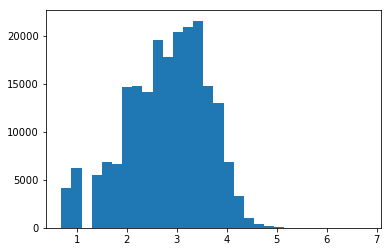

In [44]:
plt.hist(df.y,bins=30);

/home/bo/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


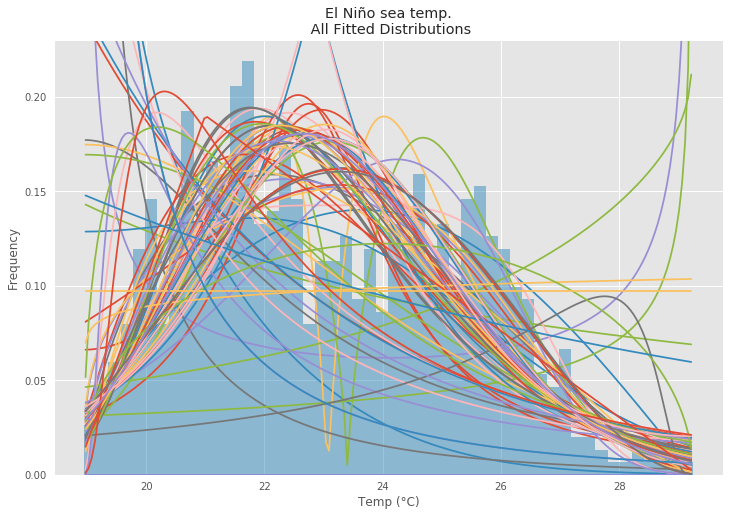

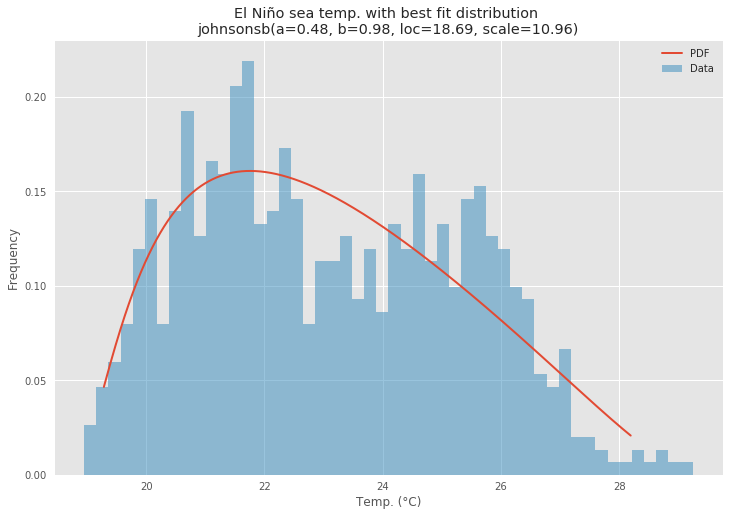

In [139]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [45]:
import seaborn as sns; sns.set(color_codes=True)

In [46]:
if 0:
    for i in range(1,8):
        plt.plot(np.arange(1,5),np.arange(1,5)*0)
        sns.kdeplot(df['y'][df['day']==i].values,df['error'][df['day']==i].values, shade=True)
        plt.show()

1


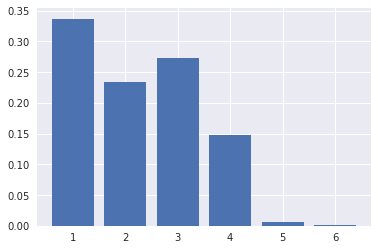

2


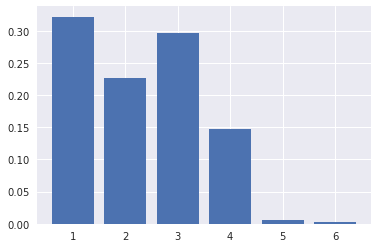

3


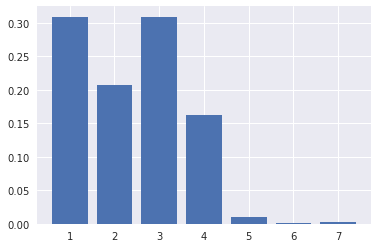

4


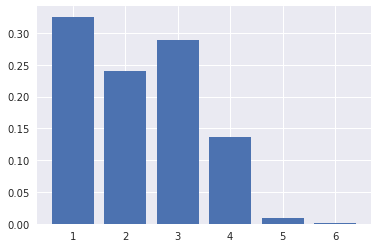

5


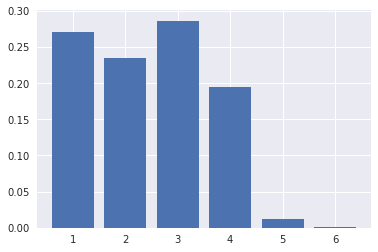

6


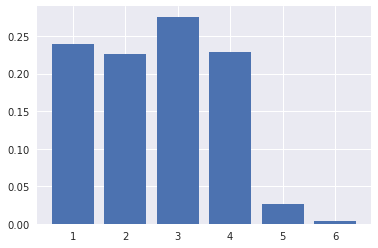

7


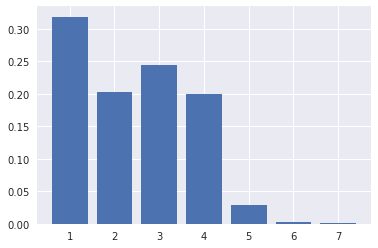

In [47]:
df['tmp']=np.round(df['y'])
for i in range(1,8):
    print i
    s=df[['tmp','error2']][df['day']==i].groupby('tmp').sum().iloc[:,0]
    plt.bar(s.index,s.values/s.sum())
    plt.show()

In [48]:
np.expm1(2)

6.3890560989306504

In [49]:
gc.collect()

43901

In [50]:
df2=df.groupby("dayidx").mean() 

In [51]:
df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())

In [52]:
df2[['day','error2']].groupby('day').median()

error2
day          
1    0.286874
2    0.258531
3    0.249613
4    0.255838
5    0.211549
6    0.217034
7    0.291647

In [53]:
rrvf_data.idx_to_date([477])

array(['2017-04-22'],
      dtype='|S10')

In [54]:
df2.tail(20)

y      pred     error    error2  day       tmp        date
dayidx                                                                   
451     2.643870  2.598027  0.045844  0.279731    1  2.635158  2017-03-27
452     2.779387  2.676809  0.102578  0.263027    2  2.771903  2017-03-28
453     2.894122  2.789493  0.104629  0.233737    3  2.902290  2017-03-29
454     2.840732  2.845125 -0.004393  0.232057    4  2.833089  2017-03-30
455     2.949381  2.919378  0.030003  0.223734    5  2.925141  2017-03-31
456     3.010427  2.979499  0.030928  0.225569    6  3.015896  2017-04-01
457     2.874227  2.868588  0.005639  0.278602    7  2.848881  2017-04-02
458     2.639812  2.628789  0.011023  0.282508    1  2.633106  2017-04-03
459     2.661434  2.669834 -0.008400  0.258567    2  2.658385  2017-04-04
460     2.733839  2.718286  0.015553  0.249293    3  2.725732  2017-04-05
461     2.660990  2.723249 -0.062259  0.264861    4  2.662182  2017-04-06
462     2.890085  2.885292  0.004794  0.216794    5  2.868759  2017-04-07
463     3.047721  3.016436  0.031285  0.198790    6  3.052023  2017-04-08
464     2.832747  2.880121 -0.047374  0.301138    7  2.822430  2017-04-09
465     2.567666  2.533677  0.033989  0.275397    1  2.568728  2017-04-10
466     2.482274  2.575128 -0.092854  0.295756    2  2.480799  2017-04-11
467     2.707616  2.644952  0.062663  0.249996    3  2.698289  2017-04-12
468     2.711302  2.688589  0.022714  0.227221    4  2.710914  2017-04-13
469     2.963810  2.912740  0.051070  0.203639    5  2.954930  2017-04-14
470     3.113366  3.089427  0.023939  0.176564    6  3.112880  2017-04-15

1


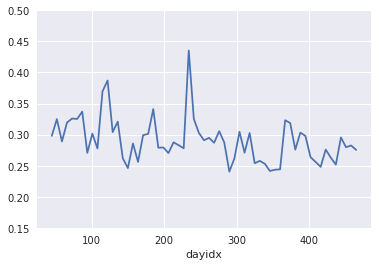

2


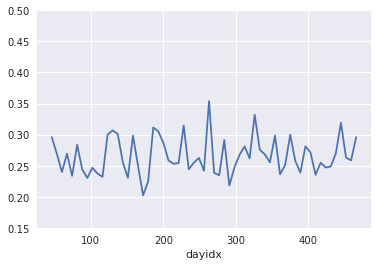

3


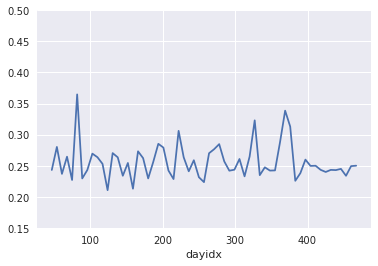

4


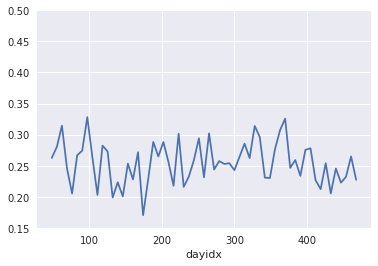

5


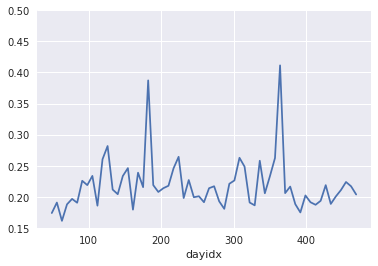

6


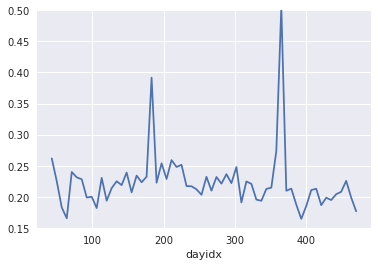

7


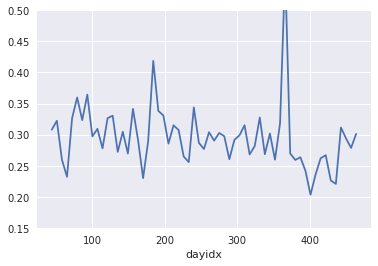

In [55]:
for i in range(1,8):
    print i
    df2[df2['day']==i]['error2'].plot();
    plt.ylim([0.15,0.5])
    plt.show()

In [56]:
df2.sort_values('error2').tail(20)

y      pred     error    error2  day       tmp        date
dayidx                                                                   
326     2.873302  2.574841  0.298461  0.331866    2  2.863636  2016-11-22
87      2.819528  2.730402  0.089126  0.337026    1  2.827273  2016-03-28
191     2.883343  2.880703  0.002640  0.338196    7  2.888889  2016-07-10
369     2.711416  2.768026 -0.056610  0.338560    3  2.716667  2017-01-04
185     2.603754  2.639800 -0.036046  0.341055    1  2.585278  2016-07-04
156     2.850538  2.904570 -0.054033  0.341393    7  2.865672  2016-06-05
240     2.804258  2.810974 -0.006716  0.343815    7  2.789675  2016-08-28
263     2.368751  2.542277 -0.173526  0.354042    2  2.364937  2016-09-20
79      3.099131  3.006759  0.092372  0.359723    7  3.123288  2016-03-20
93      2.890761  2.937673 -0.046912  0.364321    7  2.895833  2016-04-03
82      2.780752  2.776996  0.003756  0.364757    3  2.776000  2016-03-23
115     2.663079  2.662669  0.000410  0.369780    1  2.647059  2016-04-25
122     2.934453  2.675485  0.258969  0.387106    1  2.941964  2016-05-02
182     2.977611  2.953927  0.023684  0.387235    5  2.988183  2016-07-01
183     3.042553  3.011747  0.030806  0.391679    6  3.030349  2016-07-02
364     3.036973  2.975820  0.061153  0.411418    5  3.046784  2016-12-30
184     2.859933  2.882424 -0.022491  0.418727    7  2.840467  2016-07-03
234     2.352729  2.485273 -0.132544  0.435413    1  2.370019  2016-08-22
365     2.675205  2.745979 -0.070774  0.506074    6  2.667857  2016-12-31
366     2.668887  2.688414 -0.019527  0.565877    7  2.656489  2017-01-01

In [57]:
holiday=pd.read_csv('../input/date_info.csv')
holiday=holiday[holiday['holiday_flg']==1]

In [58]:
import rrvf_data

In [59]:
result=predict_test(a)

best_epochs [9, 5, 7, 4, 8]
(5803, 1) 2.70432062609 (5803, 2)


In [60]:
df=pd.DataFrame({'y':result[2][:,0]})

In [61]:
df['pred']=result[0][:,0]
df['dayidx']=result[1][:,1]

In [62]:
df=df.loc[df['y']>0]

In [63]:
df['error']=df['y']-df['pred']
df['error2']=df['error']**2


In [64]:
df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)

In [65]:
df2=df.groupby("dayidx").mean() 

In [66]:
df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())

In [67]:
df2

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923410  0.005700  0.266633    7  2017-04-16
472     2.507290  2.566220 -0.058930  0.247120    1  2017-04-17
473     2.661330  2.589721  0.071609  0.281929    2  2017-04-18
474     2.754815  2.654038  0.100777  0.240379    3  2017-04-19
475     2.713762  2.708268  0.005494  0.268506    4  2017-04-20
476     2.999000  2.897164  0.101836  0.181881    5  2017-04-21
477     3.075529  3.064519  0.011010  0.204415    6  2017-04-22

# time split

In [32]:
train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1,478-n_lookforward*4, 
                  batchsize=128,valid_split=0.0,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward,valid_type=None)
valid_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-n_lookforward*4,478-n_lookforward*2, 
                  batchsize=128,valid_split=0.0,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward,valid_type=None)
test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-n_lookforward,478, batchsize=128,lookback1=n_reg_lookback, lookforward=n_lookforward)

train has 357299 records out of 357299 records
no valid set
train has 1658 records out of 1658 records
no valid set
train has 829 records out of 829 records
no valid set


In [33]:
print train_gen.train_steps_per_epoch
print 0 if valid_gen is None else valid_gen.train_steps_per_epoch

2791
12


In [34]:
#show_features(train_gen,ondate_cols,lag_cols,rawy,0,467,filter_fn=lambda u: 'y_0' in u)

In [35]:
lag_input_dim=lag_train_test.shape[-1]
ondate_input_dim=ondate_train_test.shape[-1]
lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)

(27, 8, (1, 8))

In [36]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[3],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 3})

In [37]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [38]:
backend.clear_session()
set_session(tf.Session(config=config))   
a=rrvf.KerasModel("test", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                  ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim,
                  max_epoch=200,
                  params=parameter)
a._make_model()
a.params

(?, 42, 54)


{'activation': 'relu',
 'batch_normalization': False,
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3}

In [39]:
#a.model.summary()
print gc.collect()
a.model.count_params()

454


455425

In [40]:
a.fit(train_gen,valid_gen)

Epoch 1/200
2791/2791 [==============================] - 57s 20ms/step - loss: 0.3199 - total_loss: 0.3199 - reg_loss: 2.5995 - val_loss: 0.2717 - val_total_loss: 0.2717 - val_reg_loss: 0.9499
Epoch 2/200
2791/2791 [==============================] - 56s 20ms/step - loss: 0.2837 - total_loss: 0.2837 - reg_loss: 2.5131 - val_loss: 0.2499 - val_total_loss: 0.2499 - val_reg_loss: 0.8878
Epoch 3/200
2791/2791 [==============================] - 56s 20ms/step - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 2.4670 - val_loss: 0.2563 - val_total_loss: 0.2563 - val_reg_loss: 0.8219
Epoch 4/200
2791/2791 [==============================] - 57s 20ms/step - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 2.4382 - val_loss: 0.2747 - val_total_loss: 0.2747 - val_reg_loss: 0.8155
Epoch 5/200
2791/2791 [==============================] - 56s 20ms/step - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 2.3925 - val_loss: 0.2606 - val_total_loss: 0.2606 - val_reg_loss: 0.8171


<rrvf_model.KerasModel instance at 0x7f7e885d5d88>

In [41]:
#a.traingen=train_gen

In [42]:
a.eval_valid()

best_epochs [2, 3, 5, 1, 4]
0.258842468217 0.258842468217
(1, 0.25884246821678769)


In [43]:
yy_pred=a.predict(400)

best_epochs [1, 2, 3, 4, 5]
(829, 1) 3.02983174963 (829,)


In [44]:
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

0.190820011306 0.190820011306
(1, 0.19082001130563031)


In [49]:
n_lookforward

1

In [50]:
yy_pred=a.predict(478-n_lookforward-1)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.87643025494 (829,)
0.182698888629 0.182698888629
(1, 0.18269888862869477)


In [51]:
yy_pred=a.predict(478-n_lookforward-2)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.62079328142 (829,)
0.270138534272 0.270138534272
(1, 0.27013853427158546)


In [52]:
yy_pred=a.predict(478-n_lookforward-3)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.60231247107 (829,)
0.243763329538 0.243763329538
(1, 0.24376332953775123)


In [53]:
yy_pred=a.predict(478-n_lookforward-4)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.52984273246 (829,)
0.278246599289 0.278246599289
(1, 0.27824659928872975)


In [45]:
yy_pred=a.predict(478-n_lookforward)

best_epochs [1, 2, 3, 4, 5]
(829, 1) 3.06015446194 (829,)


In [46]:
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

0.209365883356 0.209365883356
(1, 0.20936588335586601)
